<font size=6  color=#003366> <div style="text-align: center"> [LGBIO2050] - Medical Imaging <br><br> 
<div style="text-align: center"> Active Contours </font> <br><br><br>

<font size=5  color=#003366>
<div style="text-align: left"> Professors :   
<font size=4  color=#003366>
<div style="text-align: left"> Prof. G. Kerckhofs  
<div style="text-align: left"> Prof. J. Lee <br>
<div style="text-align: left"> Prof. B. Macq <br>
<div style="text-align: left"> Prof. F. Peeters
<font size=5  color=#003366>
    
<br> <br>
<div style="text-align: left"> Teaching assistants : 
<font size=4  color=#003366>
<div style="text-align: left"> Damien Dasnoy-Sumell (damien.dasnoy@uclouvain.be)<br> 
<div style="text-align: left">Estelle Loÿen (estelle.loyen@uclouvain.be)
<font size=5  color=#003366>
<div style="text-align: right"> 2021-2022 </div>
<br><br>
</font>

<font size=6 color=#009999> 1. Guidelines and Deliverables </font> <br> <br>
   - This assignment is due on **1st December 2022**.
   - Copying code or answers from other groups (or from the internet) is strictly forbidden. Each source of inspiration must be clearly indicated.
   - The jupyter notebook containing the code and **detailed answers** to the questions must be delivered in an
archive (.zip folder) on Moodle. The answers have to be written in English.<br> <br>



<font size=6 color=#009999> 2. Context and objective </font> <br> <br>

Active Contour, also called Snake, is an image processing method proposed for the first time in 1988 that has seen many variations since. Its goal is to find the edges in an image when an approximative position is known a priori. The method consists in placing a snake composed of an ordered set of points $p_n=(x_n, y_n)$ on an image [Figure 1], and to let it deform iteratively to fit edges of the image.
<br><br>
<center>
<img src="imgs/snakeExampleImg.png" width = "300"> 
Figure 1: Example of active contours from the initial guess (in blue) to the final position (in orange).
</center>
<br> 

The final position fitting the edge is a state of lower energy based on a defined energy function $E_{snake}$. This energy is composed of an internal and external part such as:

$$ E_{snake} = E_{int} + E_{ext} $$
where 
$$E_{int} = \alpha E_{cont} + \beta E_{curv}$$
and 
$$E_{ext} = \gamma E_{image} + \delta E_{cons}$$
<br>

$E_{int}$ contains the internal energy of the snake. It is the sum of 
   - the continuity energy $E_{cont}$ which defines the elasticity of the snake, or how each point is attracted to its neighbours in function of the distance between them
   - the curvature energy $E_{curv}$ whih defines the curvature of the snake, or how each point is influenced by its 2 direct neigbours in function of the angle they form

$E_{ext}$ contains the external energy of the snake. It is the sum of
   - the external image energy $E_{image}$ which defines how the snake is drawn towards image features
   - the constraints energy $E_{cons}$ which adds constraints specific to an application

$\alpha, \beta, \gamma$ and $\delta$ are parameters used to increase or lower the importance of each part in the energy function. For example if the contour has sharp corners, the $\beta$ parameter can be lowered to allow sharper angles in the snake.  

In this challenge, we will use active contours to find the edges of a structure in the liver of a patient [Figure 2] and to track the position of this structure in a dynamic MRI sequence of several images acquired in free breathing.

<img src="imgs/ROI.png" width = "300"> 
<center>Figure 2: Example of image of the dynamic sequence and the structure of interest for this challenge (bright blob showed by the red arrow).</center>
<br><br>

<font size=6 color=#009999> 3. ROI selection </font> <br> <br>

The first step will be to load the image data and to extract the region of interest.

<div class="alert alert-info">
<b>QUESTION 1</b>  <br>
In the following cell, import the image serie from the "dataChallengeSnake.p" file. Use the given function $showImageListAsVideo$ to visualize the image serie as a video. Create a function to crop the image list around the region of interest and use the video function again on the cropped image list to see if the cropping works as expected.
</div>

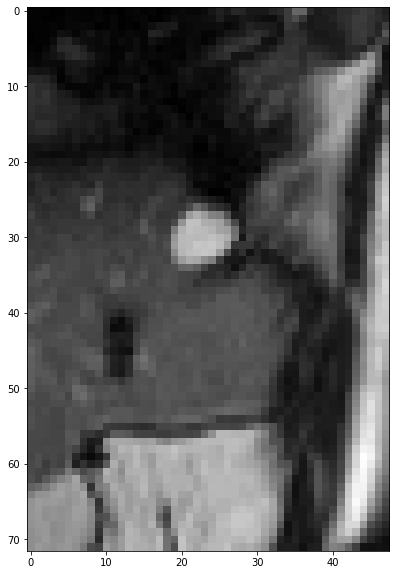

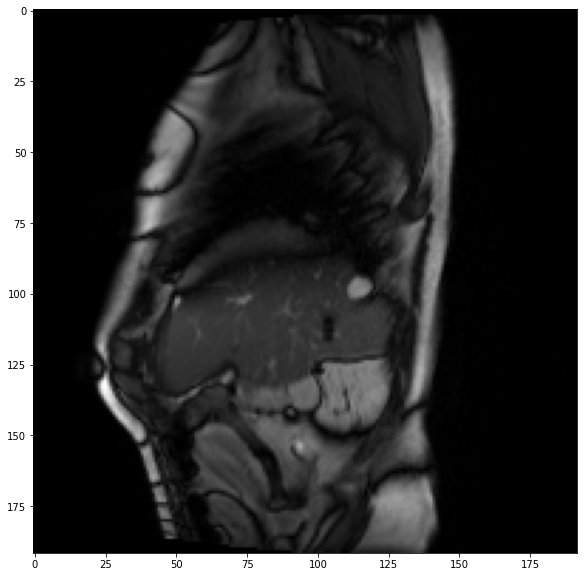

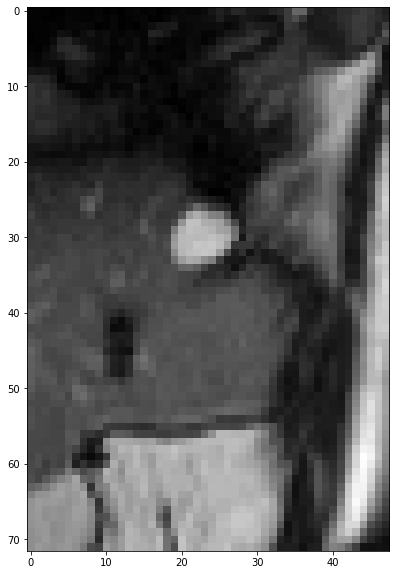

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython import display
import time

data = pickle.load(open('/home/claeys/Documents/medical_imaging/challenge6/dataChallengeSnake.p', "rb"))
imageList = data['imageSeries']

## ---------------------------------------------------------------
def showImageListAsVideo(imageList, fps=3): ## could be improved
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    for image in imageList:
        time.sleep(1/fps)
        ax.clear()
        ax.imshow(image, cmap='gray')
        display.clear_output(wait=True)
        display.display(plt.gcf())
         
## ---------------------------------------------------------------

showImageListAsVideo(imageList[:10])
#cropps
image=np.array(imageList)
roi_cropped = image[:, 68:68+72 , 92:92+48]
showImageListAsVideo(roi_cropped[:10])

<font size=6 color=#009999> 4. Implementation </font> <br> <br>
<font size=5 color=#009999> 4.1 Snake initialization </font> <br> <br>

The first step in the implementation is to implement the snake structure. As we will use a closed snake curve, the last point should be a copy of the first one.

<div class="alert alert-info">
<b>QUESTION 2</b>  <br>
In the following cell, create a function to initialize a set of points in the image. Think about the usefull parameters for this step so it is possible to modify them when calling the function. Use it to create a snake point set and show its position on the first image of the list.
</div>

In [3]:
## Snake initialization cell --> create a snake as a [N, 2] numpy array

def initial_snake(a,b,c,d, initial_time = 0, step = 0.5):
    t = np.arange(initial_time, 2*np.pi, step)
    yi = a+b*np.cos(t)
    xi = c+d*np.sin(t)
    return np.array([xi,yi]).T

<font size=5 color=#009999> 4.2 Image energy map creation </font> <br> <br>

The second step in the implementation is to extract from the image the energy map that will serve in the $E_{ext} = \gamma E_{image} + \delta E_{cons}$ part of the energy function. The goal is to preprocess the image to create a map of the image where edges have a low value, as the goal is to find the edges of the white structure in the image.

<div class="alert alert-info">
<b>QUESTION 3</b>  <br>
In the following cell, imagine a way to get an image where edges are dark and the rest is bright. Create a function to preprocess the first image of the dynamic image serie and get its energy map. Use it on the first image of the dynamic image serie and show the resulting map.
</div>

In [4]:
## image preprocessing cell to get the image energy map as a 2D numpy array

def energy_map(img):
    giy, gix = np.gradient(img)
    grad = (gix**2 + giy**2)**(0.5)
    grad = (grad - grad.min()) / (grad.max() - grad.min())
    return grad

<font size=5 color=#009999> 4.3 Active contour method </font> <br> <br>

Now you will have to implement the snake energy function. Each energy part is a metric that must be computed based on the given snake and image and aims at favorizing a particular behavior of the snake. A lower energy means that the snake current curve respects the imposed contraints.

<div class="alert alert-info">
<b>QUESTION 4</b>  <br>
In the following cell, complete the snakeEnergy function to implement an active contours method. Explain what you chose to do for each energy in the next text cell. Then observe its behavior on the first image of the serie using the next cell. (The $E_{cons}$ is not mandatory)
</div>

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython import display
import time
import cv2
from scipy import ndimage
from skimage import filters, feature, morphology
from functools import partial
from scipy import optimize, ndimage
import copy

def snakeEnergy(alpha, beta, gamma, delta,  img, flatSnakePoints,  sigma=30.):
    """
    Computes the energy of the snake.

    args:
    flatSnakePoints ((2*N,1)-shaped numpy array): A flattened list of the contour points,
    can be created by calling "ravel" on an ordered [N,2] array

    img (2D numpy array): image from which the energy map must be extracted

    alpha (float): The relative weight given to unevenly spaced points. A higher
    value encourages evenly-spaced points. Should be > 0.

    beta (float): The weight given to local curvature. A higher value encourages
    flat contours.

    return (float): Image energy
    """
    # inspiration code: brikeats /Snakes-in-a-Plane

    pts = np.reshape(flatSnakePoints, (int(len(flatSnakePoints)/2), 2))
    xi = pts[:,0]
    yi = pts[:,1]
    prior_pts = np.roll(pts, 1, axis=0)
    next_pts = np.roll(pts, -1, axis=0)

    #external_energy
    grad = energy_map(img)
    img_binary = cv2.threshold(grad, 0.255, 1, cv2.THRESH_BINARY)[1]
    skeleton = morphology.skeletonize(img_binary)
    euclid_dist = ndimage.distance_transform_edt(~skeleton)
    external_energy = ndimage.interpolation.map_coordinates(euclid_dist, [xi ,yi], order=1)
    E_ext = np.sum(external_energy)

    # E_cont (favors equi-distant points)
    #square of the absolute difference between the contour point and it's next and prior points
    displacements = pts - prior_pts
    dist = np.sqrt(displacements[:,0]**2 + displacements[:,1]**2)
    mean_dist = np.mean(dist)
    E_cont = np.sum((dist - mean_dist)**2)

    # curvature energy (favors smooth curves)
    u = -pts+prior_pts
    v = -pts+next_pts
    curvature = (u+v)
    E_curv = np.sum(curvature[:,0]**2+curvature[:,1]**2)

    return alpha*E_cont + beta*E_curv + gamma*E_ext


def active_contour(snakePointsArray, img, alpha=0.5, beta=0.25, gamma=0.4, delta=0.5, max_its=100, showResults=False):
    """
    Compute the active contour method using the snakeEnergy cost function and an optimizer

    args:
    snakePointsArray ([N,2] numpy array): The initial snake points
    img (2D numpy array): image on which to apply the active contour
    alpha (float): The weight given to continuity in the points.
    beta (float): The weight given to local curvature. Higher value --> flat snake
    gamma (float): The weight given to the external energy.
    max_its (int): The maximum number of iteration.
    showResults (boolean): set to True to show the optimization process on the image.
    returns: [N,2] numpy array: The snake points after minimization.
    """
    if showResults:
        initialSnakePoints = copy.copy(snakePointsArray)
        initialSnakePointsX, initialSnakePointsY = zip(*initialSnakePoints)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img, cmap='gray')
        ax.plot(initialSnakePointsY, initialSnakePointsX, marker='.', color='red')

        def callback_function(new_pts):
            callback_function.iterCount += 1
            for elem in ax.lines:
                elem.remove()
            ax.plot(initialSnakePointsY, initialSnakePointsX, marker='.', color='C0')
            y = new_pts[0::2]
            y = np.append(y,y[0])
            x = new_pts[1::2]
            x = np.append(x,x[0])
            ax.plot(x, y, marker='.', color='C1')
            ax.set_title('Iteration '+str(callback_function.iterCount))
            display.clear_output(wait=True)
            display.display(plt.gcf())

        callback_function.iterCount = 0
    else:
        callback_function = None

    costFunction = partial(snakeEnergy, alpha, beta, gamma, delta, img)
    options = {'disp':False}
    options['maxiter'] = max_its
    method = 'BFGS'
    resultingSnake = optimize.minimize(costFunction, snakePointsArray.ravel(), method=method, options=options, callback=callback_function)
    resultingSnake = np.reshape(resultingSnake.x, (int(len(resultingSnake.x)/2), 2))
    resultingSnake[:,[0, 1]] = resultingSnake[:,[1, 0]]

    return resultingSnake



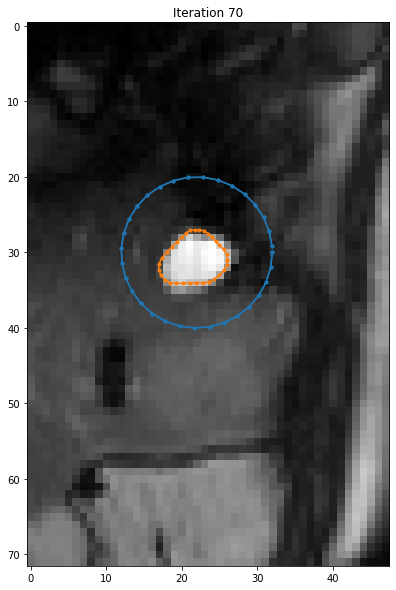

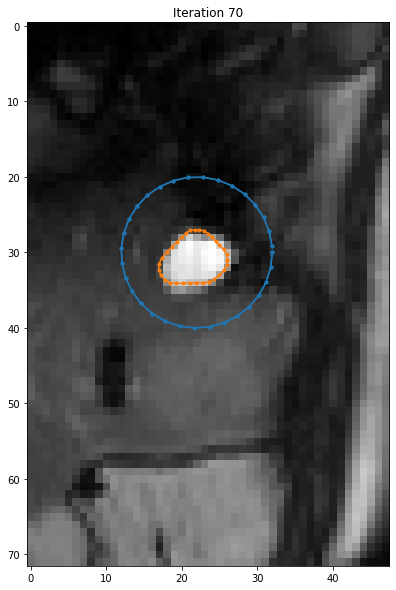

In [7]:
%matplotlib inline

##_______________________________________Parameters
snakePointsArray = initial_snake(22,10,30,10, initial_time = 0, step = 0.2)
flatSnakePoints = snakePointsArray.ravel()
snake_pts_init = active_contour(snakePointsArray, roi_cropped[0,:,:], max_its=70, alpha=1.5, beta=1.75, gamma=1.0, showResults=True)
plt.show()

<font size=5 color=#009999> 4.4 Propagate slice by slice </font> <br> <br>

<div class="alert alert-info">
<b>QUESTION 5</b>  <br>
In the following cell, use your previous implemented functions to apply the active contour method successively on the rest of the image serie. Think about an efficient way of chosing the starting snake for the successives images and explain what you chose in the next text cell. Show the results of randomly selected frames. In order to lower the computation time, adapt the number of treated images if your pc is slow (only compute the first 10 frames for exemple). 
</div>


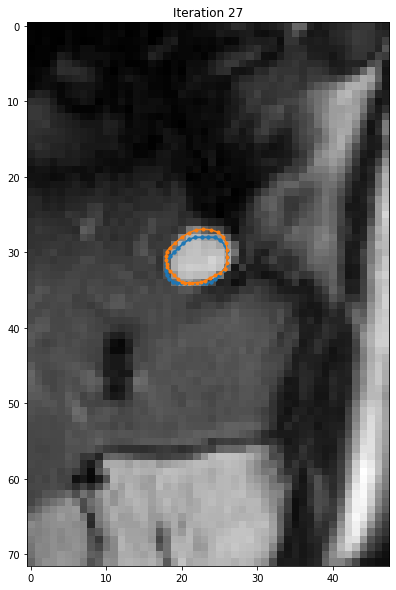

KeyboardInterrupt: 

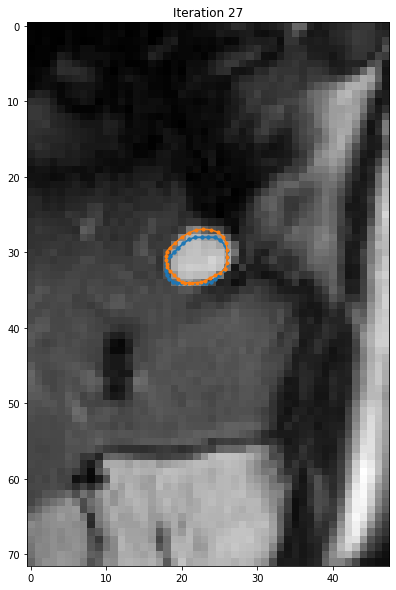

In [8]:
## Propagate to other frames
def center(snakePointsArray):
    center = [np.mean(snakePointsArray[:,1]), np.mean(snakePointsArray[:,0])]
    return center

center_motion = []
for i in range(1,10):
    snake_pts_init = np.array([snake_pts_init[:,1], snake_pts_init[:,0]]).T
    snake_pts_prev = active_contour(snake_pts_init, roi_cropped[i,:,:], max_its=70, alpha=1.5, beta=1.75, gamma=1.0, showResults=True)
    plt.show()
    center_motion.append(center(snake_pts_init))
    snake_pts_init = snake_pts_prev



Question 5 answer: We have taken the previous convergent snake as the new initial snake. We could also have computed the mass center of the previous convergent snake and create a circle around it. 

<font size=5 color=#009999> 4.5 Show ROI motion in time </font> <br> <br>

<div class="alert alert-info">
<b>QUESTION 6</b>  <br>
In the following cell, use your previous results to show separately the vertical and horizontal motion of the ROI center over time in a graph.
</div>

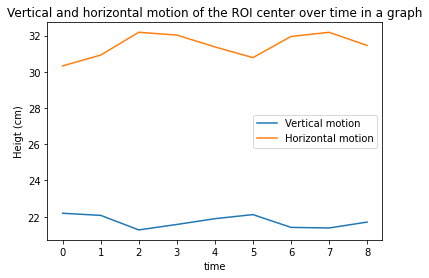

In [ ]:
## Show ROI motion

plt.plot(np.array(center_motion)[:,0], label = "Vertical motion")
plt.plot(np.array(center_motion)[:,1], label = "Horizontal motion")
plt.title("Vertical and horizontal motion of the ROI center over time in a graph")
plt.xlabel("time")
plt.ylabel("Heigt (cm)")
plt.legend()
plt.show()